## Przygotowanie

Przed rozpoczęciem pracy z notatnikiem proszę zmienić jego nazwę dodając na początku numer albumu, imię i nazwisko.
{nr_albumu}\_{imię}\_{nazwisko}\_{nazwa}

Po wykonaniu wszystkich zadań proszę przesłać wypełniony notatnik przez platformę ELF za pomocą formularza "Prześlij projekt" w odpowiedniej sekcji. 

## Regresja liniowa wieloraka

Rzadko kiedy zdarza się taka sytuacja, że zależność opisuje się na podstawie tylko jednej zmiennej. Z reguły na wynik zmiennej objaśnianej ($y$) ma wpły więcej różnych cech. Przykładowo, na cenę samochodu ma wpływ rok produkcji, przebieg, ilość koni mechanicznych itp. Dlatego właśnie jest naturalna potrzeba rozwinięcia algorytmu regresji liniowej z jedną cechą na większą ilość cech.

Algorytm, który implementowaliśmy w poprzednim zadaniu jest szczególnym przypadkiem regresji liniowej, ale może zostać on w łatwy sposób uogólniony. Mechanizmy, które poznaliśmy wcześniej takie jak obliczanie funkcji błędu, pochodnych cząstkowych, w dalszym ciągu są aktualne. Trzeba jedynie uwzględnić dodatkowe cechy.

### Zadanie 1

W zbiorze danych z zarobkami, który wykorzystywany był w poprzednim zadaniu, znajduje się pominięta wcześniej cecha. Wczytaj dane z pliku Salary.csv, tym razem z dwiema zmiennymi objaśniającymi: YearsExperience i Age oraz zmienną objaśnianą Salary. Stwórz wykres 3D przedstawiający dane.

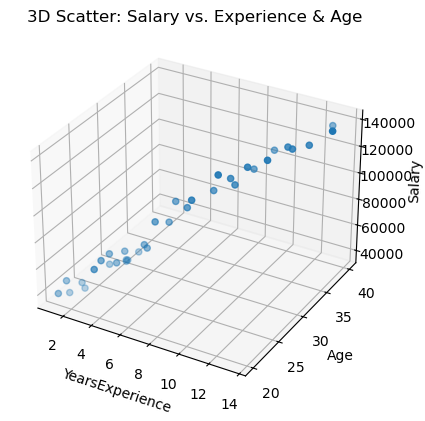

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Wczytanie danych
df = pd.read_csv('Salary.csv')

# Utworzenie trójwymiarowego wykresu punktowego
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['YearsExperience'], df['Age'], df['Salary'], marker='o')

ax.set_xlabel('YearsExperience')
ax.set_ylabel('Age')
ax.set_zlabel('Salary')
plt.title('3D Scatter: Salary vs. Experience & Age')
plt.show()


## Zadanie 2

Przerób algorytm znajdujący się w funkcji _learn_and_fit(x,y)_ w taki sposób, aby uwzględniał dodatkową cechę.
Funkcja regresji liniowej przybierze w tym momencie postać:

\begin{equation}
f(x^{(i)}) = \beta_{0} + \beta_{1}x_1 + \beta_{2}x_2 = \beta_{0} + \beta_{1} YearsExperience + \beta_{2} Age
\end{equation}

Pojawienie się kolejnej cechy wymaga akutalizacji obliczania gradientu. Należy dodatkowo obliczyć pochodną cząstkową względem parametru $\beta_{2}$, a następnie zaktualizować wartość tego parametru. 

Obliczenie pochodnej cząstkowej wygląda analogicznie jak w przypadku parametru $\beta_{1}$.

\begin{equation}
    \frac{\partial SSR}{\partial \beta_{2}} = \frac{1}{n} \sum^{n}_{i=1} (f(x^{(i)}) - y^{(i)})x_{1}^{(i)}
\end{equation}

Aktualizacja wartości współczynnika również jest analogiczna.

\begin{equation}
    \beta_{2} = \beta_{2} - \alpha \frac{\partial SSR}{\partial \beta_{2}} 
\end{equation}

_Uwaga: Zastanów się, w jaki sposób zaimplementować obługę kolejnych cech, tak aby po pojawieniu się 3 cechy nie trzeba było modyfikować algorytmu._

In [45]:
import numpy as np
import pandas as pd
import random
from typing import Tuple

def initialize_coefficients(n_features: int = 2) -> np.ndarray:
    """
    Zwraca wektor betas długości n_features+1 (pierwszy element to beta0 – wyraz wolny,
    pozostałe to współczynniki dla kolejnych cech), zainicjalizowany małymi losowymi wartościami.
    """
    # Losujemy z rozkładu normalnego o niewielkim odchyleniu
    return np.random.randn(n_features + 1) * 0.01

def calculate_regression_function(X: np.ndarray, betas: np.ndarray) -> np.ndarray:
    """
    Oblicza predykcje: f(X) = beta0 + beta1*x1 + beta2*x2 + ... + beta_n*x_n
    X ma kształt (m, n_features), betas kształt (n_features+1,)
    """
    m = X.shape[0]
    # doklejamy kolumnę jedynek pod wyraz wolny
    X_ext = np.hstack([np.ones((m, 1)), X])
    return X_ext.dot(betas)

def calculate_error(X: np.ndarray, y: np.ndarray, betas: np.ndarray) -> float:
    """
    Zwraca średni błąd kwadratowy (MSE).
    """
    preds = calculate_regression_function(X, betas)
    return np.mean((preds - y) ** 2)

def calculate_gradient(X: np.ndarray, y: np.ndarray, betas: np.ndarray) -> np.ndarray:
    """
    Oblicza wektor gradientu MSE względem wszystkich współczynników betas.
    """
    m = X.shape[0]
    X_ext = np.hstack([np.ones((m, 1)), X])
    error = X_ext.dot(betas) - y
    # gradient MSE: (2/m) * X_ext^T * error
    return (2 / m) * X_ext.T.dot(error)

def update_regression_coefficients(
    X: np.ndarray,
    y: np.ndarray,
    betas: np.ndarray,
    alpha: float
) -> np.ndarray:
    """
    Aktualizuje wektor betas o krok algorytmu gradient descent.
    """
    grad = calculate_gradient(X, y, betas)
    return betas - alpha * grad

In [46]:
import numpy as np
import pandas as pd
from typing import Tuple


def learn_and_fit(
        X: np.ndarray,
        y: np.ndarray,
        alpha: float = 0.0001,
        epochs: int = 10_000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Gradient descent dla regresji liniowej z dwiema (lub więcej) cechami.
    input:
      X      – macierz cech kształtu (m, n_features)
      y      – wektor wartości objaśnianej kształtu (m,)
    output:
      b0_list    – wektor beta0 w kolejnych epokach, kształt (epochs,)
      betas_list – macierz współczynników beta1..beta_n w kolejnych epokach, kształt (epochs, n_features)
      error_list – wektor błędu MSE w kolejnych epokach, kształt (epochs,)
    """
    m, n_features = X.shape
    # rozszerzona macierz X z kolumną jedynek
    X_ext = np.hstack([np.ones((m, 1)), X])
    # inicjalizacja betas = [beta0, beta1, ..., beta_n]
    betas = np.zeros(n_features + 1)

    b0_list = np.zeros(epochs)
    betas_list = np.zeros((epochs, n_features))
    error_list = np.zeros(epochs)

    for ep in range(epochs):
        preds = X_ext.dot(betas)
        err = preds - y

        b0_list[ep] = betas[0]
        betas_list[ep, :] = betas[1:]
        error_list[ep] = np.mean(err ** 2)

        grad = (2 / m) * X_ext.T.dot(err)
        betas -= alpha * grad

    return b0_list, betas_list, error_list


# —————  Wczytanie i przygotowanie danych  —————
df = pd.read_csv('multi_variable_regression.csv')

# wybieramy kolumny x1 i x2 jako nasze cechy
X = df[['x1', 'x2']].values  # lub: df.iloc[:, :2].values
y = df['y'].values  # wartość objaśniana

# —————  Uruchomienie algorytmu  —————
b0_hist, betas_hist, err_hist = learn_and_fit(X, y)

print("Kształt b0_hist:   ", b0_hist.shape)  # (10000,)
print("Kształt betas_hist:", betas_hist.shape)  # (10000, 2)
print("Kształt err_hist:  ", err_hist.shape)  # (10000,)


Kształt b0_hist:    (10000,)
Kształt betas_hist: (10000, 2)
Kształt err_hist:   (10000,)


### Zadanie 3

Do stworzonego z zadaniu 1 wykresu dodaj płaszczyznę regresji. Stwórz 3 wykresy przedstawiające jak zmieniała się funkcja regresji na przestrzeni epok (pierwsza, środkowa, ostatnia epoka).

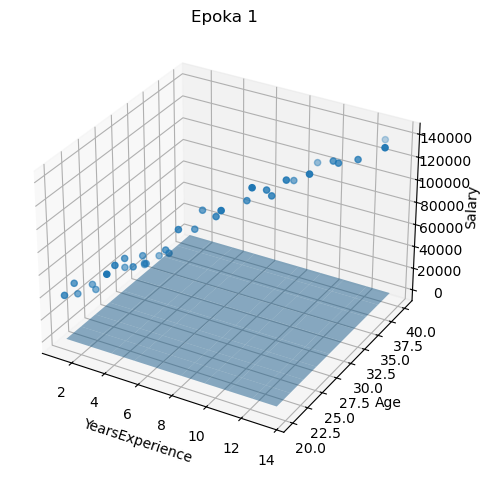

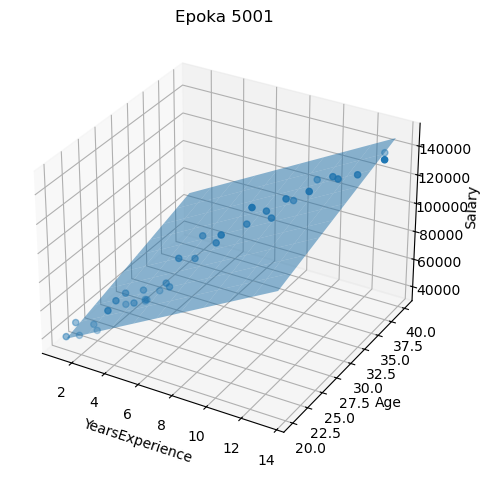

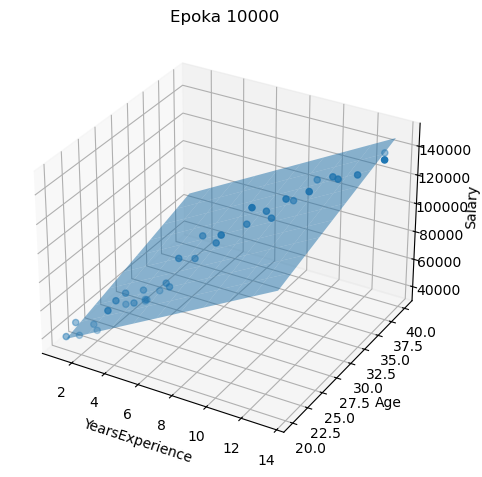

In [47]:
#YOUR CODE HEREimport numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # wymagane w niektórych wersjach matplotlib


def learn_and_fit(
        X: np.ndarray,
        y: np.ndarray,
        alpha: float = 0.0001,
        epochs: int = 10_000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    m, n = X.shape
    X_ext = np.hstack([np.ones((m, 1)), X])
    betas = np.zeros(n + 1)
    b0_hist = np.zeros(epochs)
    betas_hist = np.zeros((epochs, n))
    err_hist = np.zeros(epochs)
    for ep in range(epochs):
        preds = X_ext.dot(betas)
        err = preds - y
        b0_hist[ep] = betas[0]
        betas_hist[ep, :] = betas[1:]
        err_hist[ep] = np.mean(err ** 2)
        grad = (2 / m) * X_ext.T.dot(err)
        betas -= alpha * grad
    return b0_hist, betas_hist, err_hist


# ————— Przygotowanie danych —————
df = pd.read_csv('Salary.csv')
X = df[['YearsExperience', 'Age']].values
y = df['Salary'].values

# ————— Uczenie modelu —————
epochs = 10_000
b0_hist, betas_hist, err_hist = learn_and_fit(X, y, alpha=0.0001, epochs=epochs)

# ————— Rysowanie trzech wykresów —————
for ep in (0, epochs // 2, epochs - 1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # punkty danych
    ax.scatter(X[:, 0], X[:, 1], y, marker='o')
    # siatka płaszczyzny regresji
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 10)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 10)
    XX, YY = np.meshgrid(xx, yy)
    ZZ = b0_hist[ep] + betas_hist[ep, 0] * XX + betas_hist[ep, 1] * YY
    ax.plot_surface(XX, YY, ZZ, alpha=0.5)
    ax.set_xlabel('YearsExperience')
    ax.set_ylabel('Age')
    ax.set_zlabel('Salary')
    ax.set_title(f'Epoka {ep + 1}')
    plt.tight_layout()
    plt.show()


### Zadanie 4

W sytuacji, w której zbiór danych zawiera więcej zmiennych objaśniających niż 2, niemożliwym staje się wizualizacja prostej regresji i ocena w taki sposób stworzonego modelu. Bardzo przydatnym rozwiązaniem jest wtedy stworzenie wykresu błędów regresji. Jeśli wartości błędu spadają wraz z kolejnymi epokami, oznacza to, że jesteśmy na dobrej drodze, a nasz algorytm działa poprawnie. Celem tego zadania będzie stworzenie finalnego modelu regresji liniowej, który będzie przyjmował dowolną liczbę zmiennych objaśniających.

Na podstawie wcześniejszych implementacji, stwórz implementację funkcji *learn_and_fit_multi(X, y)*, która będzie przyjmować zbiór wejściowy z dowolną ilością kolum (cech). Dla takiego zbioru zbioru danych ma zostać stworzony model regresji. Funkcja podobnie jak wcześniej, ma zwracać współczynniki oraz wartość błędu w każdej epoce. 

W notebooku z opisem regresji liniowej przedstawione zostały wzory na ogólą postać regresji. Przeanalizuj je jeszcze raz i postaraj się je zaimplementować.

Wczytaj zestaw danych *multi_variable_regression.csv* z katalogu datasets. Dane wygenerowane zostały w taki sposób, że są wysoce liniowo zależne. Wartość błędu dla nauczonego modelu powinna być w takim przypadku niewielka. Przetestuj na wczytanym zbiorze swój algorytm.

Betas: [ 3.78481002 46.59575809 67.91670251 -4.49285389 77.89033018  5.33483804
 82.89830434]
Final MSE: 455.00983313797167


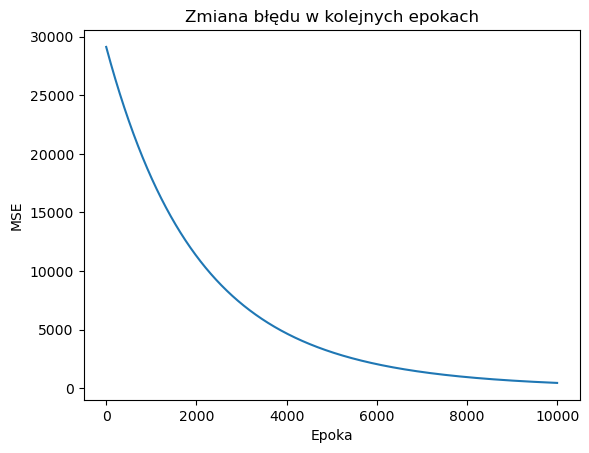

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def learn_and_fit_multi(
        X: np.ndarray,
        y: np.ndarray,
        alpha: float = 0.0001,
        epochs: int = 10000
) -> (np.ndarray, np.ndarray):
    m, n = X.shape
    X_ext = np.hstack([np.ones((m, 1)), X])
    betas = np.zeros(n + 1)
    error_history = np.zeros(epochs)
    for ep in range(epochs):
        preds = X_ext.dot(betas)
        err = preds - y
        error_history[ep] = np.mean(err ** 2)
        grad = (2 / m) * X_ext.T.dot(err)
        betas -= alpha * grad
    return betas, error_history


# Wczytanie danych
df = pd.read_csv('multi_variable_regression.csv')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Uczenie modelu
betas, error_history = learn_and_fit_multi(X, y, alpha=0.0001, epochs=10000)

# Wyniki
print("Betas:", betas)
print("Final MSE:", error_history[-1])

# Wykres błędu
plt.plot(error_history)
plt.xlabel('Epoka')
plt.ylabel('MSE')
plt.title('Zmiana błędu w kolejnych epokach')
plt.show()

### Zadanie 5

Stwórz wykres przedstawiający zmianę błędu regresji w kolejnych epokach. Napisz co można na jego podstawie wywnioskować.

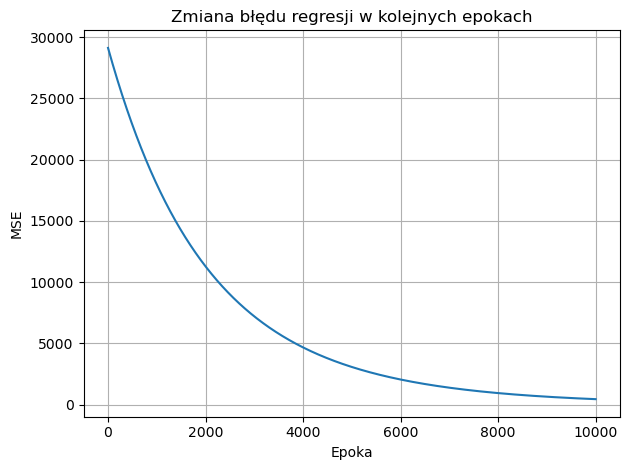

Interpretacja:
 - Jeśli wykres MSE monotonnie maleje i asymptotycznie stabilizuje się,
   oznacza to, że algorytm gradient descent poprawnie minimalizuje błąd.
 - Szybkość spadku informuje o doborze współczynnika alpha (za duży alpha może skutkować oscylacjami, za mały – powolną zbieżnością).
 - W stabilnym punkcie dalsze epoki nie przynoszą znaczącej poprawy,
   co może sugerować, że model osiągnął optymalne dopasowanie do danych.


In [49]:
# ————— Wykres błędu MSE w kolejnych epokach —————
plt.figure()
plt.plot(error_history)
plt.xlabel('Epoka')
plt.ylabel('MSE')
plt.title('Zmiana błędu regresji w kolejnych epokach')
plt.grid(True)
plt.tight_layout()
plt.show()

# ————— Interpretacja na podstawie wykresu —————
print("Interpretacja:")
print(" - Jeśli wykres MSE monotonnie maleje i asymptotycznie stabilizuje się,")
print("   oznacza to, że algorytm gradient descent poprawnie minimalizuje błąd.")
print(
    " - Szybkość spadku informuje o doborze współczynnika alpha (za duży alpha może skutkować oscylacjami, za mały – powolną zbieżnością).")
print(" - W stabilnym punkcie dalsze epoki nie przynoszą znaczącej poprawy,")
print("   co może sugerować, że model osiągnął optymalne dopasowanie do danych.")

### Zadanie 6

W jaki sposób współczynnik alpha wpływa na działania algorytmu? Przeprowadź eksperyment dla minimum trzech różnych wartości tego parametru. Sformułuj wnioski. Jak zmiana parametru wpłynęła na ilość epok w algorytmie? Jak zmieniła się funkcja regresji?

In [53]:

alphas = [1e-5, 1e-4, 1e-3]
for alpha in alphas:
    betas_a, err_hist_a = learn_and_fit_multi(X, y, alpha=alpha, epochs=10000)
    final_mse = err_hist_a[-1]
    conv_epoch = np.argmax(err_hist_a <= final_mse * 1.01) + 1
    print(f"alpha={alpha}, epoka zbieżności={conv_epoch}, betas={betas_a}")


alpha=1e-05, epoka zbieżności=9791, betas=[ 3.79339002 12.30613223 17.70109153 -4.76408362 17.36056645  0.25765768
 17.45919336]
alpha=0.0001, epoka zbieżności=9973, betas=[ 3.78481002 46.59575809 67.91670251 -4.49285389 77.89033018  5.33483804
 82.89830434]
alpha=0.001, epoka zbieżności=9997, betas=[-1.45385217e-05  4.94890372e+01  7.40470311e+01  4.30856762e+00
  8.88990580e+01  8.90991972e+00  9.87978636e+01]


### Zadanie 7

Porównaj czas działania algorytmu we własnej implementacji oraz implementacji z biblioteki Sklearn.

In [57]:
import time
from sklearn.linear_model import LinearRegression


# Pomiar czasu własnej implementacji
start = time.perf_counter()
betas_own = learn_and_fit_multi(X, y, alpha=0.0001, epochs=10000)
time_own = time.perf_counter() - start

# Pomiar czasu sklearn.LinearRegression
start = time.perf_counter()
model = LinearRegression().fit(X, y)
time_sklearn = time.perf_counter() - start
betas_sklearn = np.hstack([model.intercept_, model.coef_])

# Wyniki
print(f"Czas własnej implementacji: {time_own:.6f} s")
print(f"Czas sklearn.LinearRegression: {time_sklearn:.6f} s")
print("Współczynniki własne:", betas_own)
print("Współczynniki sklearn:", betas_sklearn)

Czas własnej implementacji: 0.092791 s
Czas sklearn.LinearRegression: 0.020446 s
Współczynniki własne: (array([ 3.78481002, 46.59575809, 67.91670251, -4.49285389, 77.89033018,
        5.33483804, 82.89830434]), array([29130.25040045, 29115.9566213 , 29101.6703438 , ...,
         455.33817153,   455.17397121,   455.00983314]))
Współczynniki sklearn: [-1.42108547e-14  4.94890407e+01  7.40470336e+01  4.30859731e+00
  8.88990575e+01  8.90992662e+00  9.87978814e+01]
